# Phase 1 — EDA & Time-Based Train/Test Split
**Dataset:** `creditcard.csv`  
**Goal:** Exploratory data analysis + temporal split. No models, no SMOTE, no scaling.

## Step 1 — Basic Checks

In [5]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import warnings
warnings.filterwarnings("ignore")

df = pd.read_csv("data/raw/creditcard.csv")

missing = df.isnull().sum()
dupes   = df.duplicated().sum()
counts  = df["Class"].value_counts().sort_index()
pcts    = df["Class"].value_counts(normalize=True).sort_index() * 100

print(f"Shape      : {df.shape[0]:,} rows × {df.shape[1]} cols")
print(f"Missing    : {missing.sum()}")
if missing.sum() > 0:
    print(missing[missing > 0])
print(f"Duplicates : {dupes:,}")
print(f"Legit (0)  : {counts[0]:,}  ({pcts[0]:.4f}%)")
print(f"Fraud (1)  : {counts[1]:,}  ({pcts[1]:.4f}%)")


Shape      : 284,807 rows × 31 cols
Missing    : 0
Duplicates : 1,081
Legit (0)  : 284,315  (99.8273%)
Fraud (1)  : 492  (0.1727%)


## Step 2 — Temporal Analysis

Time range: 0.00h → 48.00h


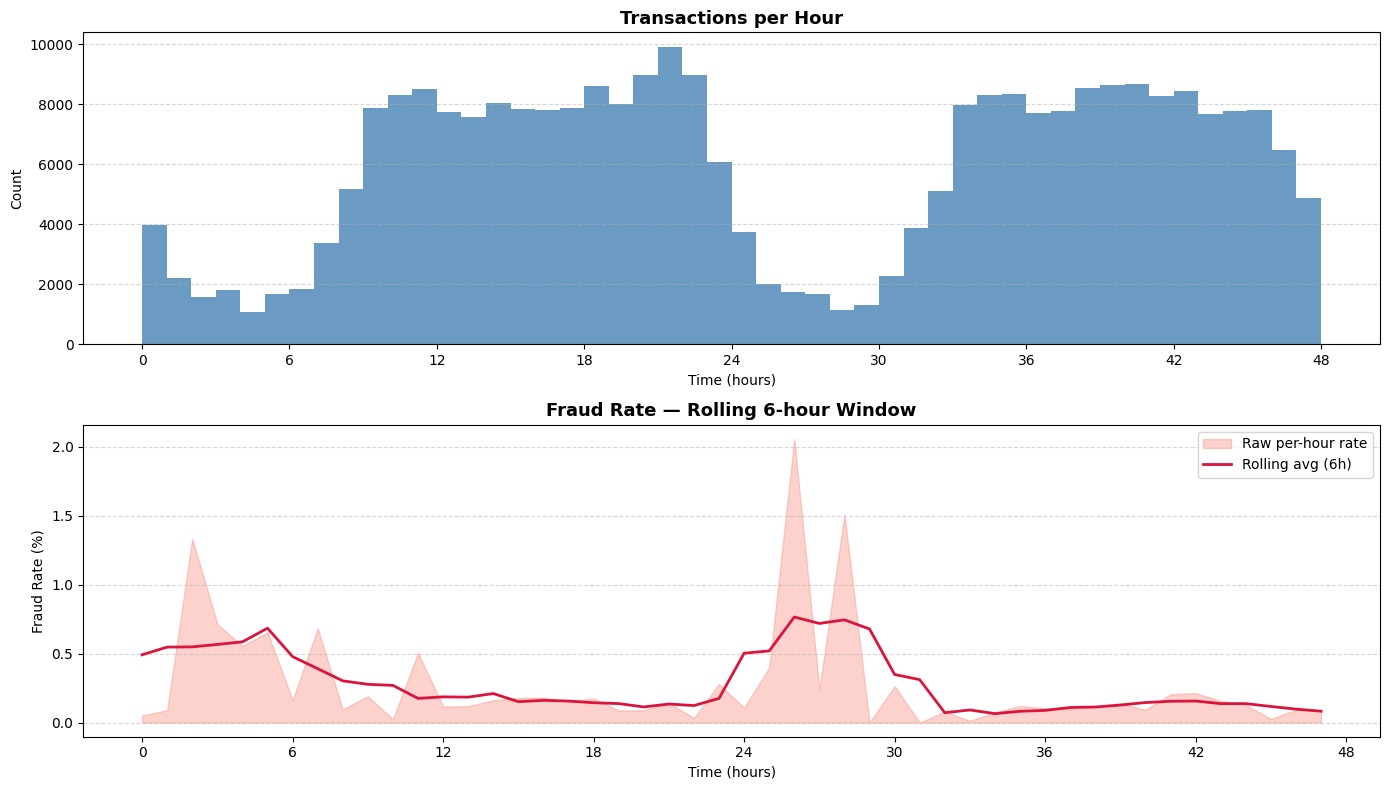

In [6]:
if not df["Time"].is_monotonic_increasing:
    df = df.sort_values("Time").reset_index(drop=True)

df["Time_hours"] = df["Time"] / 3600.0
print(f"Time range: {df['Time_hours'].min():.2f}h → {df['Time_hours'].max():.2f}h")

fig, axes = plt.subplots(2, 1, figsize=(14, 8))

max_hour = int(df["Time_hours"].max()) + 1
axes[0].hist(df["Time_hours"], bins=range(0, max_hour + 1),
             color="steelblue", edgecolor="none", alpha=0.8)
axes[0].set_title("Transactions per Hour", fontsize=13, fontweight="bold")
axes[0].set_xlabel("Time (hours)")
axes[0].set_ylabel("Count")
axes[0].xaxis.set_major_locator(mticker.MultipleLocator(6))
axes[0].grid(axis="y", linestyle="--", alpha=0.5)

df["Time_bin"] = df["Time_hours"].astype(int)
hourly = df.groupby("Time_bin")["Class"].mean().reset_index()
hourly.columns = ["Hour", "Fraud_Rate"]

WINDOW = 6
hourly["Fraud_Rate_Smooth"] = hourly["Fraud_Rate"].rolling(WINDOW, min_periods=1, center=True).mean()

axes[1].fill_between(hourly["Hour"], hourly["Fraud_Rate"] * 100,
                     color="salmon", alpha=0.35, label="Raw per-hour rate")
axes[1].plot(hourly["Hour"], hourly["Fraud_Rate_Smooth"] * 100,
             color="crimson", linewidth=2, label=f"Rolling avg ({WINDOW}h)")
axes[1].set_title(f"Fraud Rate — Rolling {WINDOW}-hour Window", fontsize=13, fontweight="bold")
axes[1].set_xlabel("Time (hours)")
axes[1].set_ylabel("Fraud Rate (%)")
axes[1].xaxis.set_major_locator(mticker.MultipleLocator(6))
axes[1].legend()
axes[1].grid(axis="y", linestyle="--", alpha=0.5)

plt.tight_layout()
plt.savefig("data/processed/temporal_analysis.png", dpi=150, bbox_inches="tight")
plt.show()


## Step 3 — Time-Based Train/Test Split
First 80% of rows (ordered by `Time`) → **Train**. Last 20% → **Test**. No `sklearn`, no shuffling.

In [7]:
df_sorted = df.sort_values("Time").reset_index(drop=True)

cutoff   = int(len(df_sorted) * 0.80)
train_df = df_sorted.iloc[:cutoff].copy()
test_df  = df_sorted.iloc[cutoff:].copy()

print(f"Total : {len(df_sorted):,}  |  cutoff = row {cutoff:,}")
print(f"Train : {len(train_df):,}  |  {train_df['Time_hours'].min():.1f}h → {train_df['Time_hours'].max():.1f}h  |  fraud={train_df['Class'].mean()*100:.4f}%")
print(f"Test  : {len(test_df):,}   |  {test_df['Time_hours'].min():.1f}h → {test_df['Time_hours'].max():.1f}h  |  fraud={test_df['Class'].mean()*100:.4f}%")


Total : 284,807  |  cutoff = row 227,845
Train : 227,845  |  0.0h → 40.3h  |  fraud=0.1830%
Test  : 56,962   |  40.3h → 48.0h  |  fraud=0.1317%


## Step 4 — Save Clean Files
Outputs written to `data/processed/`. No shuffling, no SMOTE, no scaling, no modeling.

In [8]:
import os

PROCESSED = "data/processed"
os.makedirs(PROCESSED, exist_ok=True)

DROP_COLS   = ["Time_hours", "Time_bin"]
train_clean = train_df.drop(columns=[c for c in DROP_COLS if c in train_df.columns])
test_clean  = test_df.drop(columns=[c for c in DROP_COLS if c in test_df.columns])

X_train = train_clean.drop(columns=["Class"])
y_train = train_clean[["Class"]]
X_test  = test_clean.drop(columns=["Class"])
y_test  = test_clean[["Class"]]

X_train.to_csv(f"{PROCESSED}/X_train.csv", index=False)
y_train.to_csv(f"{PROCESSED}/y_train.csv", index=False)
X_test.to_csv(f"{PROCESSED}/X_test.csv",   index=False)
y_test.to_csv(f"{PROCESSED}/y_test.csv",   index=False)

for name, obj in [("X_train", X_train), ("y_train", y_train), ("X_test", X_test), ("y_test", y_test)]:
    print(f"  {name}.csv  →  {obj.shape[0]:,} × {obj.shape[1]}")


  X_train.csv  →  227,845 × 30
  y_train.csv  →  227,845 × 1
  X_test.csv  →  56,962 × 30
  y_test.csv  →  56,962 × 1
